## Imports

In [65]:
#import os
#import glob
#import numpy as np
#import math
#import seaborn as sns
import sqlite3
import pandas as pd
import matplotlib.pylab as plt
import nltk
import pdftotext

## Variables

### Parties and elections

In [66]:
parties = ['linke', 'spd', 'grüne', 'cdu', 'fdp', 'afd']
elections = ['bt', 'eu']


### Colors

In [67]:
colors = {'linke': '#FFC0CB',
          'grüne': '#42923bff',
          'spd':   '#e2001aff',
          'cdu':   '#252422ff',
          'fdp':   '#ffec01ff',
          'afd':   '#009ee0ff'}

## Methods

### Load PDF text 

Loads political manifestos and extracts text using [pdftotext](https://github.com/jalan/pdftotext).

In [68]:
def get_pdf_text(party, election):
    with open("../rsc/wahlprogramme/{0}_{1}.pdf".format(party, election), "rb") as f:
        pdf = pdftotext.PDF(f)
        return " ".join(pdf)

### Tokenization

1. Replaces `<numbers>` by single space
2. Replaces `<non-words>-<newline><non-words>` by nothing
3. Replaces `<non-words><newline><non-words>` by single space
4. Replaces `<non-words>` by single space


In [95]:
import re

def tokenize(text):
    replaced = re.sub('\d+', ' ', text)
    replaced = re.sub('\W*-\\n\W*', '', replaced)
    replaced = re.sub('\W*\\n\W*', ' ', replaced)
    replaced = re.sub('\W+', ' ', replaced)
    return replaced.split()

### Stop words


In [126]:
from nltk.corpus import stopwords

stop = set(stopwords.words('german'))

def test_stop_word(word, mode='all'):
    return (word.lower() in stop) or (word.capitalize() in stop)

### Dictionary

In [182]:
from enchant import Dict

dic = Dict("de_DE")

def test_dictionary(word):
    return dic.check(word.lower()) or dic.check(word.capitalize())

### Lemmatization
#### Spacy lemmatizer

In [72]:
from spacy.lang.de import lemmatizer


def lemmatize_spacy(word):
    # Try to lemmatize lower word version
    try:
        return lemmatizer.LOOKUP[word.lower()]
    except: pass
    
    # Try to lemmatize capitalized word version
    try:
        return lemmatizer.LOOKUP[word.capitalize()]
    except: pass

#### Treetagger lemmatizer

In [202]:
from treetaggerwrapper import TreeTagger

tagger = TreeTagger(TAGLANG='de')

def lemmatize_tt(word):
    word_lower, word_capit = word.lower(), word.capitalize()
    
    # Try to lemmatize lower word version
    tt_lower = tagger.tag_text([word_lower], tagonly=True)[0].split('\t')[-1]
    if tt_lower != word_lower:
        return tt_lower.split("|")[-1]
    
    # Try to lemmatize capitalized word version
    tt_capit = tagger.tag_text([word_capit], tagonly=True)[0].split('\t')[-1]
    if tt_capit != word_capit:
        return tt_capit.split("|")[-1]

#### Lemmatizer combiner

In [183]:
def lemmatize_combined(word):
    sp = lemmatize_spacy(word)
    tt = lemmatize_tt(word)
    if sp and not tt:
        return sp
    if not sp and tt:
        return tt
    if tt and sp:
        return tt
    return word

### Corpus

In [494]:
def corpus(party, election, filters=[], lemmatized=True):
    raw_text = get_pdf_text(party, election)
    tokens = tokenize(raw_text)
    for token in tokens:
        if test_stop_word(token) or len(token) <= 3:
            continue
        if lemmatized:
            lem_token = lemmatize_combined(token)
            if lem_token.isalpha() and all(f(lem_token) for f in filters):
                yield lem_token
            continue
        elif all(f(token) for f in filters):
            yield token
        else:
            continue

### Visualization

In [502]:
def compare_fig(bt_data, eu_data, title):
    fig, axis = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
    fig.text(0.5, 0.04, 'Parties', ha='center')
    fig.text(0.04, 0.5, 'Words', va='center', rotation='vertical')

    plt.suptitle(title, size=20)
    axis[0].set_title("BT elections") 
    axis[0].bar(parties,
            [bt_data[party] for party in parties],
            color=[colors[party] for party in parties])

    axis[1].set_title("EU elections")
    axis[1].bar(parties,
            [eu_data[party] for party in parties],
            color=[colors[party] for party in parties])

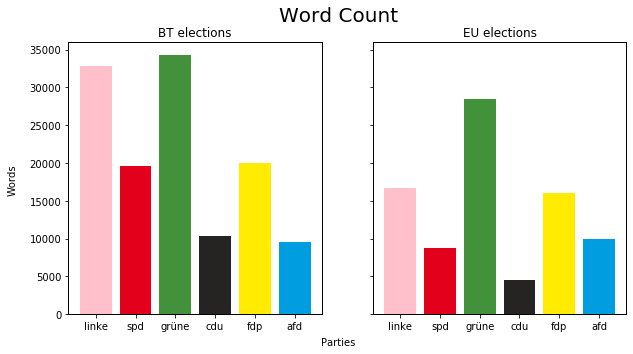

In [503]:
bt_size = {party: len(list(corpus(party, 'bt', lemmatized=False))) for party in parties}
eu_size = {party: len(list(corpus(party, 'eu', lemmatized=False))) for party in parties}
compare_fig(bt_size, eu_size, "Word Count")

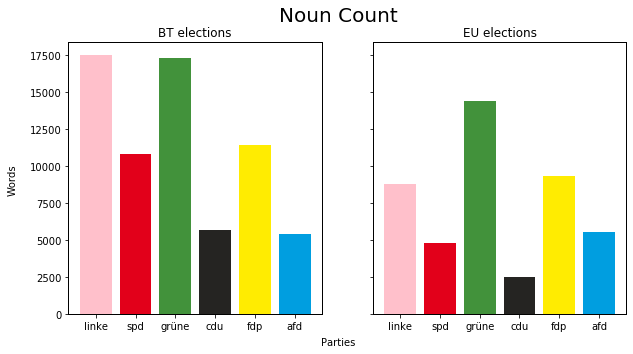

In [504]:
bt_nouns_size = {party: len(list(corpus(party, 'bt', [str.istitle], lemmatized=False))) for party in parties}
eu_nouns_size = {party: len(list(corpus(party, 'eu', [str.istitle], lemmatized=False))) for party in parties}
compare_fig(bt_nouns_size, eu_nouns_size, "Noun Count")

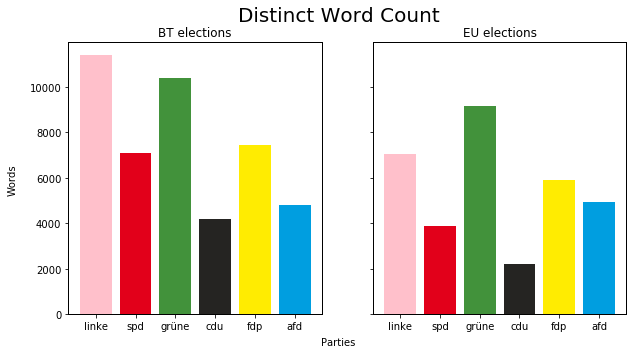

In [505]:
bt_distinct_nouns_size = {party: len(set(corpus(party, 'bt', lemmatized=False))) for party in parties}
eu_distinct_nouns_size = {party: len(set(corpus(party, 'eu', lemmatized=False))) for party in parties}
compare_fig(bt_distinct_nouns_size, eu_distinct_nouns_size, "Distinct Word Count")

## Topic analysis algorithms
### tf-idf

In [275]:
from sklearn.feature_extraction.text import TfidfVectorizer

v_bt = TfidfVectorizer(lowercase=False, sublinear_tf=True)
x_bt = v_bt.fit_transform(" ".join(corpus(party, 'bt')) for party in parties)

v_eu = TfidfVectorizer(lowercase=False, sublinear_tf=True)
x_eu = v_eu.fit_transform(" ".join(corpus(party, 'eu')) for party in parties)

Helper methods to nicely display DataFrames. 

In [277]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
def top_n(df, party, n):
    return df[[party]].sort_values(ascending=False, by=party).iloc[:n]

In [278]:
n = 15

df_bt = pd.DataFrame(x_bt.T.toarray(), index=v_bt.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_bt,party,n) for party in parties))

,linke
Ostdeutschland,0.043214
Profit,0.042516
Mindestsicherung,0.039919
Niedriglohn,0.039919
Kapitel,0.039265
Dauerstress,0.037830
Mindestrente,0.036624
Waffenexport,0.035274
Protest,0.035274
Gesundheitsversicherung,0.035274


In [279]:
n = 15

df_eu = pd.DataFrame(x_eu.T.toarray(), index=v_eu.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_eu,party,n) for party in parties))

,linke
Aufrüstung,0.051189
Umbau,0.050487
Militarisierung,0.048735
Profit,0.048581
Roma,0.048121
Pflegekraft,0.047226
Lohn,0.046654
Gliedstaat,0.046622
Wirt,0.044182
Profitinteresse,0.044182


## Visualization

The following function takes a weight matrix as an input with parties as columns and words as indices.

In [452]:
def generate_wordcloud(weight_matrix, title):
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))
    plt.suptitle(title, size=25, weight='bold')
    axis = chain.from_iterable(zip(*axs))
    for party, ax in zip(weight_matrix.columns, axis):
        # Visuals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title(party.upper(), size=20)
        color_func = lambda *args, **kwargs: colors[party]
        # Weights and Clourd
        word_weights = top_n(weight_matrix, party, 30).iloc[:,0].to_dict()
        word_cloud = WordCloud(background_color='white', height=500, width=1000, color_func=color_func)
        image = word_cloud.generate_from_frequencies(word_weights)
        ax.imshow(image, interpolation='bilinear')

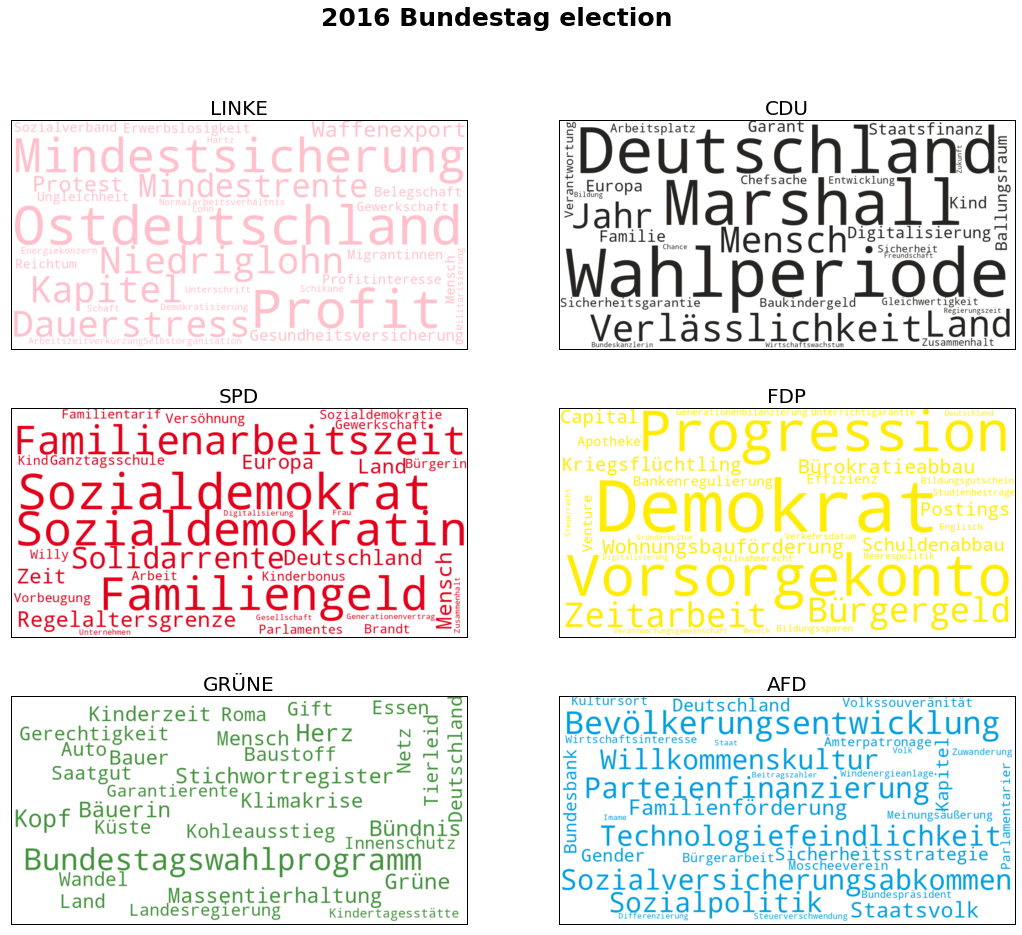

In [453]:
generate_wordcloud(df_bt, '2016 Bundestag election')

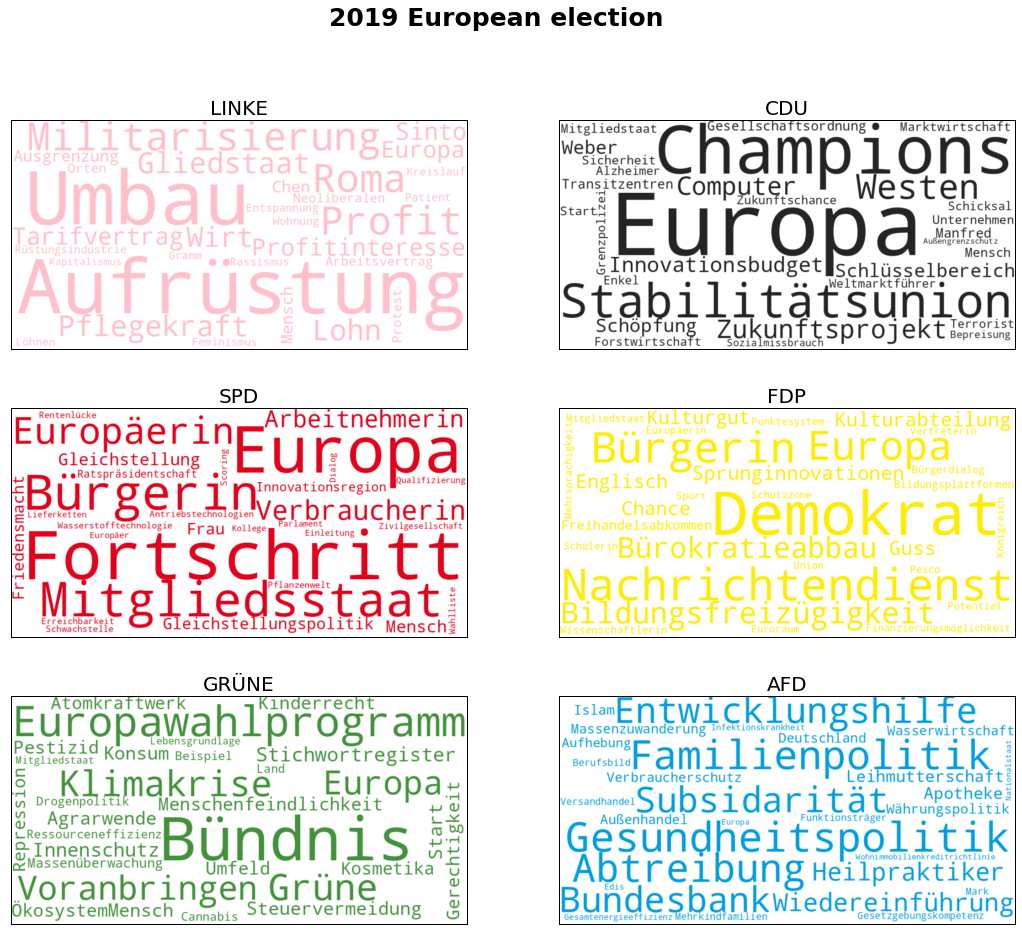

In [454]:
generate_wordcloud(df_eu, '2019 European election')